# Model Augmentation Demo

- If models are programs, then metamodeling is metaprograming

- A commutative diagram
<p><img src="src/img/semanticmodels_jl.dot.svg" alt="A diagram showing how pipelining commutes with tranforming models"></p>


# Augmenting Model Workflows

We can apply our model augmentation framework to models that are compositions of component models.

1. How does the epidemic size depend on the probability of recovering?
1. $SIR \mid y\approx ax+b$
1. What if the disease is fatal?
1. What if the population is Growing?
1. Is the relationship linear?

We are going to use the model augmentation presented in `examples/agentgraft.jl` as a baseline simulation and build a workflow to compose that model with the example in `examples/polynomial_regression.jl`. It is strongly recommended that you understand those examples before following this notebook.

This example combines an agent based model of SIR diseases with a statistical model of polynomial regression to quantify the response of the agent based model with respect to one of its parameters. The input models have to be composed carefully in order to make the software work.

As taught by the scientific computing education group [Software Carpentry](https://swcarpentry.github.io/), the best practice for composing scientific models is to have each component write files to disk and then use a workflow tool such as [Make](https://swcarpentry.github.io/make-novice/) to orchestrate the execution of the modeling scripts.

An alternative approach is to design modeling frameworks for representing the models. The problem with this avenue becomes apparent when models are composed. The frameworks must be interoperable in order to make combined models. ModelTools avoids this problem by representing the models as code and manipulating the codes. The interoperation of two models is defined by user supplied functions in a fully featured programming language. 

If a workflow is a program, t

Let $m_1,m_2$ be models, and $t_1,t_2$ be tranformations and define $M_i = t_i(m_i)$. If we denote the creation of pipelines with the function composition symbol $g\circ f$ then we want to implement everything such that the following diagram commutes.
<p><img src="../doc/build/img/commutative_pipeline.dot.svg" alt="A diagram showing how pipelining commutes with tranforming models"></p>

This example shows how you can use a pipeline to represent the combination of models and then apply combinations of transformations to that pipeline. Transforming models and composing them into pipelines are two operations that commute, you can transform then compose or compose and then transform.

In [1]:
using SemanticModels.Parsers
using SemanticModels.ModelTools
using SemanticModels.ModelTools.ExpStateModels
import Base: push!
import SemanticModels.ModelTools: model, isexpr
using Random

In [2]:
samples = 100
nsteps = 25
finalcounts = Any[]

0-element Array{Any,1}

In [3]:
println("Running Agent Based Simulation Augmentation Demo")
println("================================================")
println("demo parameters:\n\tsamples=$samples\n\tnsteps=$nsteps")

Running Agent Based Simulation Augmentation Demo
demo parameters:
	samples=100
	nsteps=25


## Baseline SIRS model

Here is the baseline model, which is read in from a text file. You could instead of using `parsefile` use a `quote/end` block to code up the baseline model in this script. 

<img src="https://docs.google.com/drawings/d/e/2PACX-1vSeA7mAQ-795lLVxCWXzbkFQaFOHMpwtB121psFV_2cSUyXPyKMtvDjssia82JvQRXS08p6FAMr1hj1/pub?w=1031&amp;h=309">

In [4]:
expr = parsefile("../examples/agentbased.jl")
m = model(ExpStateModel, expr)

function returns(block::Vector{Any})
    filter(x->(head(x)==:return), block)
end
returntuples = (bodyblock(filter(x->isa(x, Expr), findfunc(m.expr, :main))[end]) 
    |> returns 
    .|> x-> x.args[1].args )
push!(returntuples[1], :((ρ=ρ, μ=μ, n=n)))

3-element Array{Any,1}:
 :newsam                 
 :counts                 
 :((ρ = ρ, μ = μ, n = n))

In [5]:
m

ExpStateModel(
  states=:([:S, :I, :R]),
  agents=Expr[:(a = sm.agents), :(a = fill(:S, n))],
  transitions=Expr[:(T = Dict(:S => (x...->begin
                      #= none:120 =#
                      if rand(Float64) < stateload(x[1], :I)
                          :I
                      else
                          :S
                      end
                  end), :I => (x...->begin
                      #= none:121 =#
                      if rand(Float64) < ρ
                          :I
                      else
                          :R
                      end
                  end), :R => (x...->begin
                      #= none:122 =#
                      if rand(Float64) < μ
                          :R
                      else
                          :S
                      end
                  end)))]
)

In [6]:
magents = m
println("\nRunning basic model")
eval(m.expr)
for i in 1:samples
    #println(("=======  Simulation $i  ========"))
    newsam, counts, params = AgentModels.main(nsteps)
    push!(finalcounts, (model=:basic, counts=counts, params=params))
end


Running basic model


In [7]:
@show length(finalcounts)
finalcounts

length(finalcounts) = 100


100-element Array{Any,1}:
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>5, :I=>8, :R=>7], params = (ρ = 0.5044597668576319, μ = 0.5, n = 20))  
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>17, :I=>1, :R=>2], params = (ρ = 0.3816620127536393, μ = 0.5, n = 20)) 
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>8, :I=>6, :R=>6], params = (ρ = 0.36862644317003945, μ = 0.5, n = 20)) 
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>15, :I=>2, :R=>3], params = (ρ = 0.14121610255839134, μ = 0.5, n = 20))
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>15, :I=>0, :R=>5], params = (ρ = 0.0, μ = 0.5, n = 20))                
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>6, :I=>9, :R=>5], params = (ρ = 0.46599559388695944, μ = 0.5, n = 20)) 
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>10, :I=>4, :R=>6], params = (ρ = 0.6669682789732478, μ = 0.5, n = 20)) 
 (model = :basic, counts = Pair{Symbol,Int64}[:S=>6, :I=>10, :R=>4], params = (ρ = 0.5396782020468529, μ = 0.5, n = 20))

In [8]:
ModelTools.invoke(magents, 10)[2:end]

(Pair{Symbol,Int64}[:S=>10, :I=>5, :R=>5], (ρ = 0.638700168810345, μ = 0.5, n = 20))

## Statistical Regression Model
The following expression defines a univariate polynomial regression model of degree 0, which just computes the average of target variable. This model can be augmented to an polynomial regression model using transformations
$T_1,T_x$ which will be defined later.

In [9]:

expr = quote
    module Regression
    using Random
    using LsqFit
    using LinearAlgebra

    function f(x, β) 
        return .+(β[1].* x.^0)
    end

    function describe(fit)
        if !fit.converged
            error("Did not converge")
        end
        return (β = fit.param, r=norm(fit.resid,2), n=length(fit.resid))
    end
    #setup
    a₀ = [1.0]
    function main(X, target)
        #solving
        fit = curve_fit(f, X, target, a₀)#, autodiff=:forwarddiff)
        result = describe(fit)
        return fit, result
    end
end
end
Regression = eval(expr.args[2])

Main.Regression

In [10]:
function connector(finalcounts, i, j)
    n = length(finalcounts)
    Data = zeros(n,length(finalcounts[1].counts))
    params = zeros(n,length(finalcounts[1].params))
    @show size(Data)
    for i in 1:n
        c = finalcounts[i].counts
        Data[i, : ] = map(last, c)
        params[i,:] = collect(map(float, finalcounts[i].params))
    end
    X = params[:, i]
    Y = Data[:, j]
    @show sum(Y)/length(Y)
    @assert size(X,1) == size(Y,1)
    return X,Y
end


connector (generic function with 1 method)

In [13]:
X,Y = connector(finalcounts, 1, 3)
collect(zip(X,Y))[1:5]

size(Data) = (100, 3)
sum(Y) / length(Y) = 4.37


5-element Array{Tuple{Float64,Float64},1}:
 (0.5044597668576319, 7.0) 
 (0.3816620127536393, 2.0) 
 (0.36862644317003945, 6.0)
 (0.14121610255839134, 3.0)
 (0.0, 5.0)                

In [15]:
fit, result = Regression.main(connector(finalcounts, 1,3)...)
result

size(Data) = (100, 3)
sum(Y) / length(Y) = 4.37


(β = [4.37], r = 27.987675859206316, n = 100)

In [16]:
if sum(fit.resid)/length(fit.resid) > 1e-8
    @warn "Mean residual is large, regression might have failed"
end

## Implementation Details
The following code is the implementation details for representing the models as an `AbstractProblem` and representing the transformations as `Product{Tuple{Pow{Int}, Pow{Int}}}` and applying the transformations onto the models.

See the `examples/polynomial_regression.jl` example for details of what this code does.

In [17]:
using LinearAlgebra
using SemanticModels
using SemanticModels.ModelTools
using SemanticModels.ModelTools.Transformations
import SemanticModels.ModelTools: model, AbstractModel, isexpr
import SemanticModels.Parsers: findfunc, findassign
import Base: show

In [18]:
"""    Lsq


A program that solves min_β || f(X,β) - y ||_2

Example:

`f(X, β) = β[1].*X.^p .+ β[2].*X.^q`

See also [`(t::Pow)(m::MultivariateLsq)`](@ref)
"""
struct Lsq <: AbstractModel
    expr
    f
    coefficient
    p₀
end

function show(io::IO, m::Lsq)
    write(io, "Lsq(\n  f=$(repr(m.f)),\n  coefficient=$(repr(m.coefficient)),\n  p₀=$(repr(m.p₀))\n)")
end

function model(::Type{Lsq}, expr::Expr)
    if expr.head == :block
        return model(Lsq, expr.args[2])
    end
    objective = :l2norm
    f = callsites(expr, :curve_fit)[end].args[2]
    coeff = callsites(expr, f)[1].args[end]
    p₀ = callsites(expr, :curve_fit)[end].args[end]
    return Lsq(expr, f, coeff, p₀)
end

"""    poly(m::Lsq)::Expr

find the part of the model that implements the polynomial model for regression.
"""
function poly(m::Lsq)
    func = findfunc(m.expr, m.f)[1]
    poly = func.args[2].args[end].args[1]
    return poly
end

"""    (t::Pow)(m::Lsq)

Example:

If `m` is a program implementing `f(X, β) = β[1]*X^p + β[2]*X^q`

a) and `t = Pow(2)` then `t(m)` is the model implementing
`f(X, β) = β[1]*X^p+2 + β[2]*X^q+q`.

"""
function (t::Pow)(m::Lsq)
    p = poly(m)
    for i in 2:length(p.args)
        slot = p.args[i]
        pow = callsites(slot, :(.^))
        pow[end].args[3] += t.inc
    end
    return m
end

SemanticModels.ModelTools.Transformations.Pow

In [19]:
struct AddConst <: Transformations.Transformation end

"""    (c::AddConst)(m::MultivariateLsq)

Example:

If `m` is a program implementing `f(X, β) = β[1]*X^p + β[2]*X^q`

a) and `c = AddConst()` then `c(m)` is the model implementing
`f(X, β) = β[1]*X^p + β[2]*X^0`.

"""
function (c::AddConst)(m::Lsq)
    p = poly(m)
    ix = map(t->t.args[2].args[2], p.args[2:end])
    i = maximum(ix)+1
    push!(p.args, :(β[$i].*x.^0))
    assigns = findassign(m.expr, m.p₀)
    b = assigns[end].args[2].args
    push!(b, 1)
    return m
end

Tₓ = Pow(1)
T₁ = AddConst();


# Model workflows

Models can be chained together into workflows, the most basic type is a pipeline where the outputs from model $m_i$ are passed to model $m_{i+1}$. One area where traditional modeling frameworks get in trouble is the fact that the connections between the models can be arbitrarily complex. Thus any modeling framework that supports worflows, must embed a programming language for describing the connectors between the steps of the workflow.

Since we are already embedded in Julia, we will use regular Julia functions for the connectors.

Mathematically, a pipeline is defined as $r_n = P(m_1,\dots,m_n, c_1,\dots,c_n)$ based on the recurrence,

$r_0 = m_1(c)$ where $c$ is a constant value, and 

$r_i = m_i(c_i(r_{i-1}))$


We store the values of $r_i$ in the field results so that they can be accessed later by visualization and  analysis programs.

## Model Workflows

- Pipelines connect models in sequence like a bash script.
- $input \mid m_1 \mid c_1 \mid m_2 \mid c_2 \mid \dots \mid m_n > output$

In [20]:
module Pipelines
using SemanticModels.ModelTools
using Random
struct Pipeline <: AbstractModel
    steps
    connectors
    results
end

function run!(p::Pipeline)
    stages = length(p.steps)
    connectors = p.connectors
    for s in 1:stages
        data = p.results[end]
        r = connectors[s](p.steps[s], data...)
        push!(p.results, r)
    end
end

function reset!(p::Pipeline)
    while length(p.results) > 1
        pop!(p.results)
    end
    return p
end
end

Main.Pipelines

## Running the baseline workflow

This workflow connects the two models so that we simulate the agent based model and then perform a regression on the outputs.

In [22]:
m = model(Lsq, deepcopy(expr))
mstats = deepcopy(m)
P = Pipelines.Pipeline(deepcopy.([magents, mstats]),
    [(m, args...) -> begin 
            Random.seed!(42)
            results = Any[]
            Mod = eval(m.expr)
            for i in 1:samples
                r = Base.invokelatest(Mod.main, args...)
                push!(results, (model=:basic, counts=r[2], params=r[3]))
                #push!(results, r)
            end
            return [results]
                end,
        (m, results...) -> begin
            data = connector(results..., 1, 3)
            Mod = eval(m.expr)
            Base.invokelatest(Mod.main, data...) end
        ],
        Any[(10)]
        )    

Main.Pipelines.Pipeline(AbstractModel[ExpStateModel(
  states=:([:S, :I, :R]),
  agents=Expr[:(a = sm.agents), :(a = fill(:S, n))],
  transitions=Expr[:(T = Dict(:S => (x...->begin
                      #= none:120 =#
                      if rand(Float64) < stateload(x[1], :I)
                          :I
                      else
                          :S
                      end
                  end), :I => (x...->begin
                      #= none:121 =#
                      if rand(Float64) < ρ
                          :I
                      else
                          :R
                      end
                  end), :R => (x...->begin
                      #= none:122 =#
                      if rand(Float64) < μ
                          :R
                      else
                          :S
                      end
                  end)))]
), Lsq(
  f=:f,
  coefficient=:β,
  p₀=:a₀
)], Function[##15#17(), ##16#18()], Any[10])

Warning: Pipelines can only be run once. Recreate the pipeline and run it again if necessary.

In [23]:
Pipelines.run!(P)

size(Data) = (100, 3)
sum(Y) / length(Y) = 3.98


In [24]:
#Pipelines.run!(P)
r =  P.results[end][end]

(β = [3.98], r = 22.93381782433967, n = 100)

In [25]:
map(P.results[2][1]) do s
    last(s.counts[end])
    end |> sum |> x-> x/length(P.results[2][1])

#P.connectors[1](P.steps[3], P.results[2])

3.98

ρ	f(ρ,β)
β: [3.98]
(.+)(β[1] .* x .^ 0)


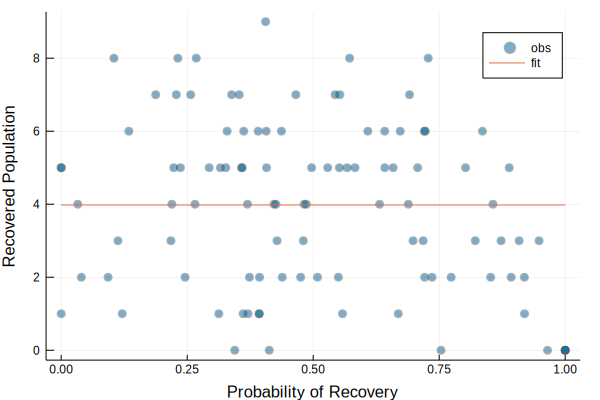

In [26]:
using Printf
eval(:(f(x,β) = $(poly(P.steps[2]))))
xdomain = (0.0:0.05:1.0)
println("ρ\tf(ρ,β)\n==============")
xŷ = zip(xdomain, f(xdomain, P.results[end][2].β))
z = collect(map(x->(@sprintf("%0.2f", x[1]),
                    @sprintf("%7.3f", x[2])),
        xŷ))

using Plots
table = map(x->(round(x.params.ρ, digits=4), last(x.counts[end])), P.results[2][1]) |> sort
p = scatter(first.(table), last.(table), label="obs",alpha=0.3)
plot!(first.(xŷ), last.(xŷ), label="fit")
xlabel!(p, "Probability of Recovery")
ylabel!(p, "Recovered Population")
println("β: ", P.results[end][2].β, "\n", string(poly(P.steps[2])))
p

## Transforming the Pipeline

- Define $\times$ so that $T_1\times T_2$ acts on a pipeline by creating $P(T_1(m_1),T_2(m_2), c_1,c_2)$.

- The following diagram commutes
<p><img src="src/img/commutative_pipeline.dot.svg" alt="A diagram showing how pipelining commutes with tranforming models"></p>

In [27]:
# Product = ModelTools.Transformations.Product
# Apply the i-th transformation to the i-th step of the pipeline
function (t::Product)(m::Pipelines.Pipeline)
    for (i, s) in enumerate(m.steps)
        t.dims[i](s)
    end
end
import LinearAlgebra: ×
×(f,g) = Product((f,g))

cross (generic function with 3 methods)

In [28]:
P.steps[2]

Lsq(
  f=:f,
  coefficient=:β,
  p₀=:a₀
)

In [29]:
# Transforming the second step
(identity × Tₓ)(P)
(identity × T₁)(P)
(identity × Tₓ)(P)
(identity × T₁)(P)

Pipelines.reset!(P)
Pipelines.run!(P);

size(Data) = (100, 3)
sum(Y) / length(Y) = 3.98


In [30]:
P.results[end][2]

(β = [-8.38778, 6.57654, 3.34351], r = 21.461856101484337, n = 100)

## Adding the Dead State

<img src="https://docs.google.com/drawings/d/e/2PACX-1vRUhrX6GzMzNRWr0GI3pDp9DvSqJVTDVpy9SNNBIB08b7Hyf9vaHobE2knrGPda4My9f_o9gncG34pF/pub?w=1028&amp;h=309">

We are going to add an additional state to the model to represent the infectious disease fatalities. The user must specify what that concept means in terms of the name for the new state and the behavior of that state. `D` is a terminal state for a finite automata.

In [31]:
function addstate!(m::ExpStateModel)
    println("\nThe system states are $(m.states.args)")
    println("\nAdding un estado de los muertos")

    put!(m, ExpStateTransition(:D, :((x...)->:D)))

    println("\nThe system states are $(m.states.args)")
    # once you are dead, you are dead forever
    println("\nThere is no resurrection in this model")
    println("\nInfected individuals recover or die in one step")

    # replace!(m, ExpStateTransition(:I, :((x...)->rand(Bool) ? :D : :I)))
    m[:I] = :((x...)->begin
            roll = rand()
            if roll < ρ
                return :R
            elseif rand(Bool)
                return :D
            else
                return :I
            end
        end
    )
    @show m[:I]
    return m
end

addstate! (generic function with 1 method)

Some utilities for manipulating functions at a higher level than expressions.

In [32]:

struct Func end

function push!(::Func, func::Expr, ex::Expr)
    push!(bodyblock(func), ex)
end

push! (generic function with 84 methods)

## Population Growth

Another change we can make to our model is the introduction of population growth. Our model for population is that on each timestep, one new suceptible person will be added to the list of agents. We use the `tick!` function as an anchor point for this transformation.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vRfLcbPPaQq6jmxheWApqidYte8FxK7p0Ebs2EyW2pY3ougNh5YiMjA0NbRMuGAIT5pD02WNEoOfdCd/pub?w=1005&amp;h=247">

In [33]:
function addgrowth!(m::ExpStateModel)
    println("\nAdding population growth to this model")
    stepr = filter(x->isa(x,Expr), findfunc(m.expr, :tick!))[1]
    @show stepr
    push!(Func(), stepr, :(push!(sm.agents, :S)))
    println("------------------------")
    @show stepr;
    return m
end

addgrowth! (generic function with 1 method)

## Model Augmentation yields polynomial regression
Given transformations

1. `f(x) -> xf(x)` 
2. `f(x) -> f(x) + beta`

we are able to generate all possible polynomial regression using composition of these transformations.

In [34]:
# Let's build an instance of the model object from the code snippet expr
m = model(Lsq, deepcopy(expr))
mstats = deepcopy(m)
@show m
poly(m)

m = Lsq(
  f=:f,
  coefficient=:β,
  p₀=:a₀
)


:((.+)(β[1] .* x .^ 0))

### Generating the Transformation Monoid

1. $T_x,T_1$ are *generators* for our monoid of transformations $T = \langle T_x, T_1 \rangle$.
2. $T_x$ multiplies by $x$
3. $T_1$ adds a constant to our polynomial 
4. Any polynomial can be generated by these two operations cf. Horner's rule.

In [35]:
Tₓ = Pow(1)
T₁ = AddConst();

m′ = deepcopy(m)
Tₓ(m′)
T₁(m′)
@show poly(m)
Regression = eval(m′.expr)

@show poly(m′)
fit′, result′ = Regression.main(connector(finalcounts)...)
result′

poly(m) = :((.+)(β[1] .* x .^ 0))
poly(m′) = :(β[1] .* x .^ 1 .+ β[2] .* x .^ 0)


MethodError: MethodError: no method matching connector(::Array{Any,1})
Closest candidates are:
  connector(::Any, !Matched::Any, !Matched::Any) at In[10]:14

In [36]:
for i in 1:10
    Tₓ(m′)
#    Tₓ(m′)
    T₁(m′)
end

@show poly(m)
Regression = eval(m′.expr)

@show poly(m′)
fit′, result′ = Regression.main(connector(finalcounts)...)
result′

poly(m) = :((.+)(β[1] .* x .^ 0))
poly(m′) = :(.+(β[1] .* x .^ 11, β[2] .* x .^ 10, β[3] .* x .^ 9, β[4] .* x .^ 8, β[5] .* x .^ 7, β[6] .* x .^ 6, β[7] .* x .^ 5, β[8] .* x .^ 4, β[9] .* x .^ 3, β[10] .* x .^ 2, β[11] .* x .^ 1, β[12] .* x .^ 0))


MethodError: MethodError: no method matching connector(::Array{Any,1})
Closest candidates are:
  connector(::Any, !Matched::Any, !Matched::Any) at In[10]:14

In [37]:
function connector(finalcounts, i, j)
    n = length(finalcounts)
    Data = zeros(n,length(finalcounts[1].counts))
    params = zeros(n,length(finalcounts[1].params))
    @show size(Data)
    for i in 1:n
        c = finalcounts[i].counts
        Data[i, : ] = map(last, c)
        params[i,:] = collect(map(float, finalcounts[i].params))
    end
    X = params[:, i]
    Y = Data[:, j]
    @assert size(X,1) == size(Y,1)
    return X,Y
end

connector (generic function with 1 method)

In [38]:
P = Pipelines.Pipeline(deepcopy.([magents, mstats]),
    [(m, args...) -> begin 
            Random.seed!(42)
            results = Any[]
            Mod = eval(m.expr)
            @show Mod
            for i in 1:samples
                r = Base.invokelatest(Mod.main, args...)
                push!(results, (model=:basic, counts=r[2],params=r[3]))
                #push!(results, r)
            end
            return [results]
                end,
        (m, results...) -> begin
            data = connector(results..., 1, 4)
            Mod = eval(m.expr)
            Base.invokelatest(Mod.main, data...) 
        end
        ],
        Any[(10)]
        )

Main.Pipelines.Pipeline(AbstractModel[ExpStateModel(
  states=:([:S, :I, :R]),
  agents=Expr[:(a = sm.agents), :(a = fill(:S, n))],
  transitions=Expr[:(T = Dict(:S => (x...->begin
                      #= none:120 =#
                      if rand(Float64) < stateload(x[1], :I)
                          :I
                      else
                          :S
                      end
                  end), :I => (x...->begin
                      #= none:121 =#
                      if rand(Float64) < ρ
                          :I
                      else
                          :R
                      end
                  end), :R => (x...->begin
                      #= none:122 =#
                      if rand(Float64) < μ
                          :R
                      else
                          :S
                      end
                  end)))]
), Lsq(
  f=:f,
  coefficient=:β,
  p₀=:a₀
)], Function[##29#31(), ##30#32()], Any[10])

In [39]:
println("\nInitial Pipeline")
println("----------------")
P.steps[1].states, poly(P.steps[2])


Initial Pipeline
----------------


(:([:S, :I, :R]), :((.+)(β[1] .* x .^ 0)))

In [40]:
println("\n\nApplying the first pair of transformations")
println(     "------------------------------------------")
(addstate! × one(Pow))(P)



Applying the first pair of transformations
------------------------------------------

The system states are Any[:(:S), :(:I), :(:R)]

Adding un estado de los muertos

The system states are Any[:(:S), :(:I), :(:R), :(:D)]

There is no resurrection in this model

Infected individuals recover or die in one step
m[:I] = :(x...->begin
          #= In[31]:13 =#
          #= In[31]:14 =#
          roll = rand()
          #= In[31]:15 =#
          if roll < ρ
              #= In[31]:16 =#
              return :R
          elseif #= In[31]:17 =# rand(Bool)
              #= In[31]:18 =#
              return :D
          else
              #= In[31]:20 =#
              return :I
          end
      end)


In [41]:
P.steps[1].states, poly(P.steps[2])

(:([:S, :I, :R, :D]), :((.+)(β[1] .* x .^ 1)))

In [42]:
println("\n\nApplying the second pair of transformations")
println(    "-------------------------------------------")
(addgrowth! × T₁)(P)
(identity   × Tₓ)(P)
(identity   × T₁)(P)
(identity   × Tₓ)(P)
(identity   × Tₓ)(P)
(identity   × T₁)(P)



Applying the second pair of transformations
-------------------------------------------

Adding population growth to this model
stepr = :(function tick!(sm::StateModel)
      #= none:59 =#
      sm.loads = map((s->begin
                      #= none:59 =#
                      stateload(sm, s)
                  end), sm.states)
      #= none:60 =#
      return sm.loads
  end)
------------------------
stepr = :(function tick!(sm::StateModel)
      #= none:59 =#
      sm.loads = map((s->begin
                      #= none:59 =#
                      stateload(sm, s)
                  end), sm.states)
      #= none:60 =#
      return sm.loads
      push!(sm.agents, :S)
  end)


In [43]:
println("\n\nThe final model state")
println(     "---------------------")
println(filter(isexpr, findfunc(P.steps[1].expr, :tick!))[end])
P.steps[1].states, poly(P.steps[2])



The final model state
---------------------
function tick!(sm::StateModel)
    #= none:59 =#
    sm.loads = map((s->begin
                    #= none:59 =#
                    stateload(sm, s)
                end), sm.states)
    #= none:60 =#
    return sm.loads
    push!(sm.agents, :S)
end


(:([:S, :I, :R, :D]), :(.+(β[1] .* x .^ 4, β[2] .* x .^ 3, β[3] .* x .^ 2, β[4] .* x .^ 0)))

## Running the new pipeline

now that we have transformed the pipeline we run it to build the results

In [44]:
Pipelines.run!(P)

Mod = Main.AgentModels
size(Data) = 

(100, 4)


In [45]:
#Pipelines.run!(P)
P.results[end][2]

(β = [-65.4064, 142.05, -91.1202, 14.3129], r = 25.54426623549937, n = 100)

Here is the data we observed when running the first stage of the pipeline, stage two fits a polynomial to these observations

In [46]:
table = map(x->(round(x.params.ρ, digits=4), last(x.counts[end])), P.results[2][1]) |> sort
try 
    using Plots
catch
    @warn "Plotting is not available, make a table"
    for t in table
        println(join(t, "\t"))
    end
end

## Results

The regression model that we have trained based on the simulated data from the SIRD model with population growth can be presented as a polynomial sampled over the domain. We construct this table to show the nonlinear dependence of the model on the recovery parameter $\rho$. The best fitting polynomial is shown below.

## Results

- The pipeline produces a regression polynomial
- This shows the nonlinear dependence of the model on the recovery rate $\rho$

ρ	f(ρ,β)
0.00	 14.313
0.05	 14.102
0.10	 13.537
0.15	 12.709
0.20	 11.700
0.25	 10.582
0.30	  9.418
0.35	  8.260
0.40	  7.150
0.45	  6.123
0.50	  5.201
0.55	  4.398
0.60	  3.716
0.65	  3.150
0.70	  2.683
0.75	  2.290
0.80	  1.935
0.85	  1.572
0.90	  1.147
0.95	  0.593
1.00	 -0.164
β: [-65.4064, 142.05, -91.1202, 14.3129]
.+(β[1] .* x .^ 4, β[2] .* x .^ 3, β[3] .* x .^ 2, β[4] .* x .^ 0)


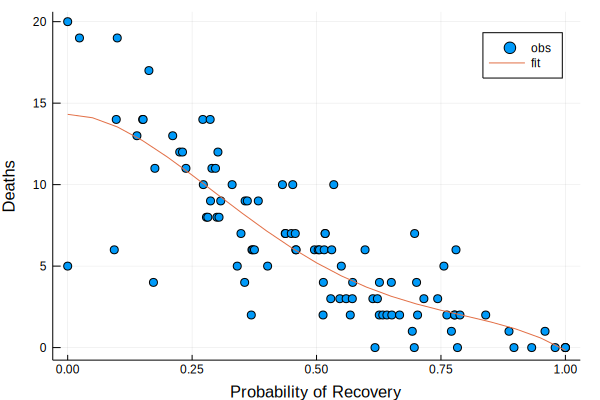

In [47]:
using Printf
eval(:(f(x,β) = $(poly(P.steps[2]))))
xdomain = (0.0:0.05:1.0)
println("ρ\tf(ρ,β)\n==============")
xŷ = zip(xdomain, f(xdomain, P.results[end][2].β))
z = collect(map(x->(@sprintf("%0.2f", x[1]),
                    @sprintf("%7.3f", x[2])),
        xŷ))
for t in z
    println(join(t, "\t"))
end

using Plots

p = scatter(first.(table), last.(table), label="obs")
plot!(first.(xŷ), last.(xŷ), label="fit")
xlabel!(p, "Probability of Recovery")
ylabel!(p, "Deaths")
println("β: ", P.results[end][2].β, "\n", string(poly(P.steps[2])))
p

## Conclusions

This example shows that the SemanticModels approach to post-hoc modeling frameworks can enable metamodeling which is the combinations of model composed using different technologies into a coherent modeling workflow. Our ModelTools provides the basic building blocks for representing models and transformations in such a way that they transformations can be composed and models can be combined. Composition of transformations respects the combination of models. In this case the Product of transformation respects the Pipeline of models. Such that you can transform the models and then pipeline them, or pipeline them and then transform them.

This example combined an agent based model of SIR diseases with a statistical model of polynomial regression to quantify the response of the agent based model with respect to one of its parameters. The input models have to be composed carefully in order to make the software work.

As taught by the scientific computing education group [Software Carpentry](https://swcarpentry.github.io/), the best practice for composing scientific models is to have each component write files to disk and then use a workflow tool such as [Make](https://swcarpentry.github.io/make-novice/) to orchestrate the execution of the modeling scripts.

An alternative approach is to design modeling frameworks for representing the models. The problem with this avenue becomes apparent when models are composed. The frameworks must be interoperable in order to make combined models. ModelTools avoids this problem by representing the models as code and manipulating the codes. The interoperation of two models is defined by user supplied functions in a fully featured programming language. 

SemanticModels.jl also provides transformations on these models that are grounded in category theory and abstract algebra. The concepts of category theory such as Functors and Product Categories allow us to build a general framework fit for any modeling task. In the language of category theory, the Pipelining functor on models commutes with the Product functor on transformations.

This examples shows that metamodeling is feasible with SemanticModels and that the algebras of model transformations can be preserved when acting on metamodel workflows.